In [91]:
import sys

import numpy as np
from sklearn.externals import joblib
from sklearn import model_selection
from sklearn import metrics
from scipy import stats
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif'] = 'Arial'
nov_formats = {
    'ClassA': ['#1f77b4', '-'],
    'ClassB': ['#ff7f0e', '--'],
    'ClassC': ['#2ca02c', ':'],
    'ClassD': ['#d62728', '-.']
}

np.set_printoptions(3)
sys.path.append('../')

from Sonar import StackedAutoEncoderCV as SAE

# Configuration

In [98]:
data_file = '/home/natmourajr/Public/Marinha/Data/DadosCiodaro/4classes/lofar_data_file_fft_1024_decimation_3_spectrum_left_400.jbl'
seed = 10
ntrn = 0.8
flag_mse = False

# Load Data

In [3]:
dataset = joblib.load(data_file)
data  = dataset[0]
target= dataset[1]
labels= dataset[2]

# Load Models

In [4]:
models = {}
for k,v in labels.items():
    print '==== Known class: ', v
    models[v] = SAE.StackedAutoEncoderCV()
    models[v].load('../Models/single_%s.jbl'%v)

==== Known class:  ClassA
Loading from  ../Models/single_ClassA.jbl


/home/sonar/Sonar/virtualenv/sonar/lib/python2.7/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


==== Known class:  ClassB
Loading from  ../Models/single_ClassB.jbl
==== Known class:  ClassC
Loading from  ../Models/single_ClassC.jbl
==== Known class:  ClassD
Loading from  ../Models/single_ClassD.jbl


#  Run Models

In [99]:
nov_errors = {}
test_errors = {}
cv_errors = {}
nov_reco = {'mse': {}, 'kl-div': {}}
known_reco = {'mse': {}, 'kl-div': {}}
train_reco = {'mse': {}, 'kl-div': {}}
for k,v in labels.items():
    print '==== Known class: ', v
    # Get the expected error from CV training
    nnet = models[v].network
    if flag_mse:
        cv_errors[v] = (models[v].results['mean_test_mse'],
                        models[v].results['std_test_mse'])
    else:
        cv_errors[v] = (-models[v].results['mean_test_kl_div'],
                        -models[v].results['std_test_kl_div'])
    print '\tExpected limits: %.6f, %.6f'%(cv_errors[v][0]-cv_errors[v][1],
                                           cv_errors[v][0]+cv_errors[v][1])
                                           
    # Get test data for known class
    X = data[target == k]
    T = target[target == k]
    Xtrn, Xtst, Ytrn, Ytst = model_selection.train_test_split(X, T, test_size = 1.0-ntrn,
                                                              stratify=T, random_state = seed)     
    # Simulate for train data of known class                                                          
    Y = models[v].predict(Xtrn)
    train_reco['mse'][v] = np.mean(np.power(Y - Xtrn,2), axis=1)
    train_reco['kl-div'][v] = np.array([nnet.calculate_score(y.reshape(1,y.shape[0]),
                                                             x.reshape(1,x.shape[0])) for x,y in zip(Xtrn, Y)])
    # Simulate for test data of known class
    Y = models[v].predict(Xtst)
    known_reco['mse'][v] = np.mean(np.power(Y - Xtst,2), axis=1)
    known_reco['kl-div'][v] = np.array([nnet.calculate_score(y.reshape(1,y.shape[0]),
                                                             x.reshape(1,x.shape[0])) for x,y in zip(Xtst, Y)])
    if flag_mse:
        test_errors[v] = metrics.mean_squared_error(Y, Xtst)
    else:
        test_errors[v] = models[v].score(Xtst)
    print '\tTest error: %.6f'%test_errors[v]
    
    # Get the error for the novelties
    print '\tNovelties'
    nov_errors[v] = {}
    nov_reco['mse'][v] = {}
    nov_reco['kl-div'][v] = {}    
    for inov, nov in labels.items():
        if inov == k: continue
        Y = models[v].predict(data[target == inov])
        nov_reco['mse'][v][nov]    = np.mean(np.power(Y - data[target == inov],2), axis=1)
        nov_reco['kl-div'][v][nov] = np.array([nnet.calculate_score(y.reshape(1,y.shape[0]),
                                                                    x.reshape(1,x.shape[0]))
                                               for x,y in zip(data[target == inov], Y)])
        if flag_mse:
            nov_errors[v][nov] = metrics.mean_squared_error(Y, data[target == inov])
        else:
            nov_errors[v][nov] = models[v].score(data[target == inov])
        print '\t\t', nov, ': %.6f'%(nov_errors[v][nov])

==== Known class:  ClassA
	Expected limits: 0.193959, 0.192423
	Test error: 0.191272
	Novelties
		ClassB : 0.198038
		ClassC : 0.195304
		ClassD : 0.198356
==== Known class:  ClassB
	Expected limits: 0.193564, 0.192806
	Test error: 0.192976
	Novelties
		ClassA : 0.204813
		ClassC : 0.199003
		ClassD : 0.200669
==== Known class:  ClassC
	Expected limits: 0.193610, 0.192484
	Test error: 0.193785
	Novelties
		ClassA : 0.204334
		ClassB : 0.200590
		ClassD : 0.202434
==== Known class:  ClassD
	Expected limits: 0.191704, 0.190071
	Test error: 0.191720
	Novelties
		ClassA : 0.203071
		ClassB : 0.198990
		ClassC : 0.198581


# Densities

## MSE

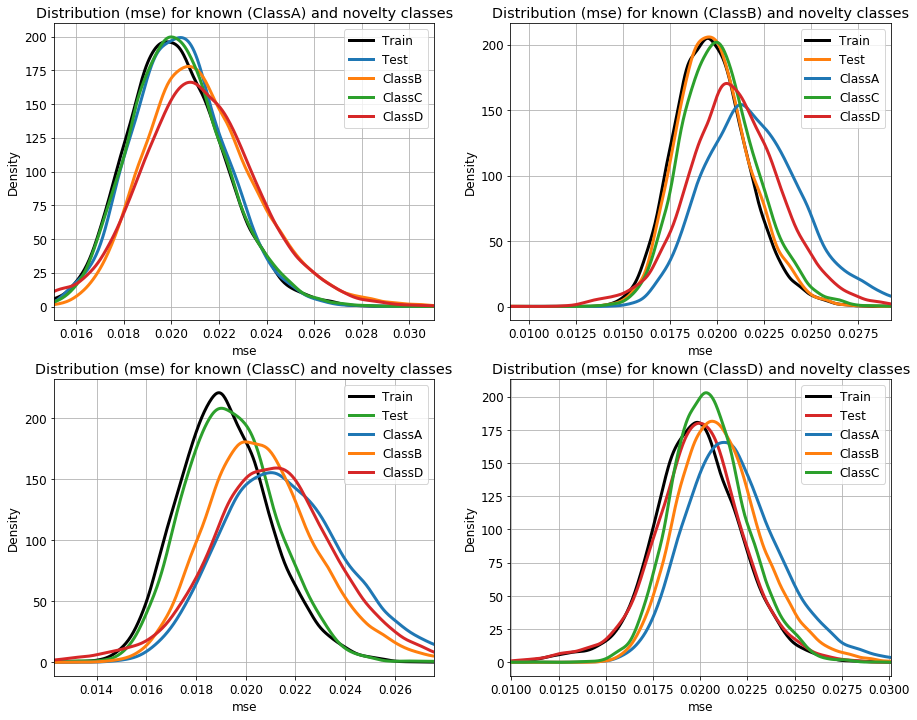

In [96]:
metric    = 'mse'
plt.figure(figsize=(15,12))
for icls, known_cls in enumerate(np.sort(known_reco[metric].keys())):
    ax = plt.subplot(2,2,icls+1)
    plt.title('Distribution (%s) for known (%s) and novelty classes'%(metric, known_cls))
    # Known Class - Train
    df = pandas.DataFrame(train_reco[metric][known_cls], columns=['Train'])
    df.plot(kind='kde', ax=ax, color='k')
    # Known Class - Test
    df = pandas.DataFrame(known_reco[metric][known_cls], columns=['Test'])
    df.plot(kind='kde', ax=ax, color=nov_formats[known_cls][0])
    # Novelties
    for nov_cls in np.sort(nov_reco[metric][known_cls].keys()):
        df = pandas.DataFrame(nov_reco[metric][known_cls][nov_cls], columns=[nov_cls])
        df.plot(kind='kde', ax=ax, color=nov_formats[nov_cls][0])
    ax.set_xlim((np.min(known_reco[metric][known_cls]), np.max(known_reco[metric][known_cls])))
    plt.grid()
    plt.xlabel(metric)

## Kullback-Leibler

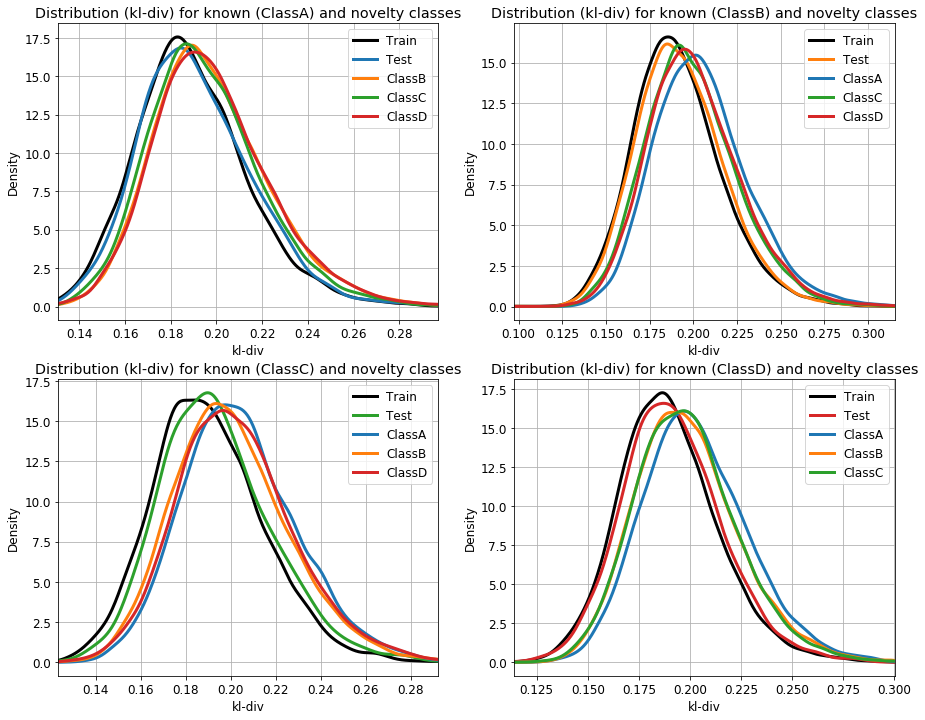

In [97]:
metric = 'kl-div'
plt.figure(figsize=(15,12))
for icls, known_cls in enumerate(np.sort(known_reco[metric].keys())):
    ax = plt.subplot(2,2,icls+1)
    plt.title('Distribution (%s) for known (%s) and novelty classes'%(metric, known_cls))
    # Known Class - Train
    df = pandas.DataFrame(train_reco[metric][known_cls], columns=['Train'])
    df.plot(kind='kde', ax=ax, color='k')
    # Known Class - Test
    df = pandas.DataFrame(known_reco[metric][known_cls], columns=['Test'])
    df.plot(kind='kde', ax=ax, color=nov_formats[known_cls][0])
    # Novelties
    for nov_cls in np.sort(nov_reco[metric][known_cls].keys()):
        df = pandas.DataFrame(nov_reco[metric][known_cls][nov_cls], columns=[nov_cls])
        df.plot(kind='kde', ax=ax, color=nov_formats[nov_cls][0])
    ax.set_xlim((np.min(known_reco[metric][known_cls]), np.max(known_reco[metric][known_cls])))
    plt.grid()
    plt.xlabel(metric)